<a href="https://colab.research.google.com/github/gitswathig/assignment3/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TASK-3**

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt

from google.colab import files


In [ ]:
# Load Dataset
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded.keys())))
df.head()


Saving Dataset .csv to Dataset .csv


,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


In [ ]:
#  Cleaning

df = df.drop_duplicates()
df['Cuisines'] = df['Cuisines'].astype(str).str.split(',').str[0].str.strip()

# Handle missing
df['Cuisines'] = df['Cuisines'].replace("Unknown", np.nan)
df.dropna(subset=['Cuisines'], inplace=True)

# Target labels
y = df['Cuisines']

# Features
X = df.drop(columns=['Cuisines'])


In [ ]:
# Feature Identification


text_cols = []

for col in X.columns:
    if X[col].dtype == object and "name" in col.lower():
        text_cols.append(col)

# Fallback if name column missing
if not text_cols:
    text_cols = [X.select_dtypes(include='object').columns[0]]

categorical_cols = [
    col for col in X.columns
    if X[col].dtype == object and col not in text_cols
]

numerical_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

print("Text columns:", text_cols)
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)


Text columns: ['Restaurant Name']
Categorical columns: ['City', 'Address', 'Locality', 'Locality Verbose', 'Currency', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu', 'Rating color', 'Rating text']
Numerical columns: ['Restaurant ID', 'Country Code', 'Longitude', 'Latitude', 'Average Cost for two', 'Price range', 'Aggregate rating', 'Votes']


In [ ]:
# Preprocessing Pipeline

preprocess = ColumnTransformer([
    ("text", TfidfVectorizer(stop_words='english'), text_cols[0]),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='drop')


In [ ]:
# samples
counts = y.value_counts()
valid_cuisines = counts[counts >= 2].index
X = X[y.isin(valid_cuisines)]
y = y[y.isin(valid_cuisines)]

# Now stratified split works
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train samples:", len(X_train))
print("Test samples:", len(X_test))


Train samples: 7624
Test samples: 1906


In [9]:
#  Train Classification Models

models = {
    "Logistic Regression": LogisticRegression(max_iter=300),
    "Random Forest": RandomForestClassifier(n_estimators=250, random_state=42)
}

results = {}

for name, model in models.items():
    clf = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

results


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Logistic Regression': {'Accuracy': 0.5550891920251836,
  'Precision': 0.5406030466341714,
  'Recall': 0.5550891920251836,
  'F1 Score': 0.5116111011672705},
 'Random Forest': {'Accuracy': 0.5577124868835257,
  'Precision': 0.5708428008226982,
  'Recall': 0.5577124868835257,
  'F1 Score': 0.5135832035260263}}

In [10]:
#  Detailed Classification
clf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(n_estimators=250, random_state=42))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


                   precision    recall  f1-score   support

          Afghani       1.00      1.00      1.00         1
         American       0.43      0.57      0.49        56
           Andhra       0.00      0.00      0.00         1
          Arabian       0.00      0.00      0.00         1
            Asian       0.50      0.07      0.12        15
         Assamese       0.00      0.00      0.00         1
           Awadhi       0.00      0.00      0.00         1
              BBQ       0.00      0.00      0.00         4
           Bakery       0.78      0.50      0.61       124
         Bar Food       0.00      0.00      0.00         2
          Bengali       0.00      0.00      0.00         4
        Beverages       1.00      0.25      0.40        16
           Bihari       0.00      0.00      0.00         1
          Biryani       0.68      0.65      0.67        23
        Brazilian       0.50      1.00      0.67         5
        Breakfast       0.00      0.00      0.00       

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

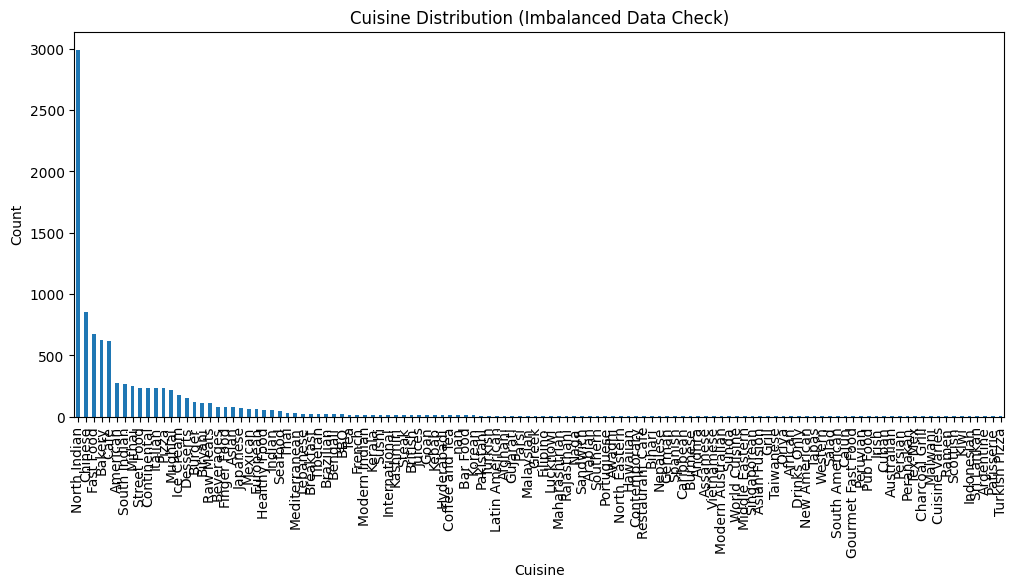

In [11]:
#  Class Distribution
plt.figure(figsize=(12,5))
df['Cuisines'].value_counts().plot(kind='bar')
plt.title("Cuisine Distribution (Imbalanced Data Check)")
plt.xlabel("Cuisine")
plt.ylabel("Count")
plt.show()
